### **Pipeline du Groupe A** 

Pipeline du Groupe A,
Il faut avoir deux bases de données dans son drive 
https://drive.google.com/file/d/1xkuT88-x06LEb5f6Lr0BEzVP--gAims8/view?usp=sharing 
*Le code suivant l'importe et l'installe dans les fichiers du Colab*

In [ ]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


### *Récupération du DataSet initial*

In [ ]:
link = 'https://drive.google.com/file/d/1xkuT88-x06LEb5f6Lr0BEzVP--gAims8/view?usp=sharing'
  
import pandas as pd
  
# to get the id part of the file
id = link.split("/")[-2]
  
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('PRI.csv.gz',)  
  
fulldata = pd.read_csv('PRI.csv.gz', )


*Regardons la tête du DataSet*

In [ ]:
fulldata.head()

,EventId,PRI_had_pt,PRI_had_eta,PRI_had_phi,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_met,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label,detailLabel
0,100000,32.638,1.017,0.381,51.626,2.273,-2.414,16.824,-0.277,258.733,2,67.435,2.150,0.444,46.062,1.24,-2.475,113.497,0.001333,1.0,2
1,100001,42.014,2.039,-3.011,36.918,0.501,0.103,44.704,-1.916,164.546,1,46.226,0.725,1.158,-999.000,-999.00,-999.000,46.226,1.114509,0.0,400
2,100002,32.154,-0.705,-2.093,121.409,-0.953,1.052,54.283,-2.186,260.414,1,44.251,2.053,-2.028,-999.000,-999.00,-999.000,44.251,1.171295,0.0,400
3,100003,22.647,-1.655,0.010,53.321,-0.522,-3.100,31.082,0.060,86.062,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,-0.000,2.717621,0.0,400
4,100004,28.209,-2.197,-2.231,29.774,0.798,1.569,2.723,-0.871,53.131,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,3.116281,0.0,400


# Systematic uncertainties

In [ ]:
les_param=[[1.05,1,1,1,0],[1,1.5,1,1,0],[1,1,1.03,1,0],[1,1,1,1.03,0],[1,1,1,1,3]]

In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
from __future__ import division
from __future__ import print_function
from __future__ import absolute_import

import sys
import os
import gzip
import copy
import pandas as pd
import numpy as np

class V4:
    """
    A simple 4-vector class to ease calculation, work easy peasy on numpy vector of 4 vector
    """
    px=0
    py=0
    pz=0
    e=0
    def __init__(self,apx=0., apy=0., apz=0., ae=0.):
        """
        Constructor with 4 coordinates
        """
        self.px = apx
        self.py = apy
        self.pz = apz
        self.e = ae
        if self.e + 1e-3 < self.p():
            raise ValueError("Energy is too small! Energy: {}, p: {}".format(self.e, self.p()))

    def copy(self):
        return copy.deepcopy(self)
    
    def p2(self):
        return self.px**2 + self.py**2 + self.pz**2
    
    def p(self):
        return np.sqrt(self.p2())
    
    def pt2(self):
        return self.px**2 + self.py**2
    
    def pt(self):
        return np.sqrt(self.pt2())
    
    def m(self):
        return np.sqrt( np.abs( self.e**2 - self.p2() ) ) # abs is needed for protection
    
    def eta(self):
        return np.arcsinh( self.pz/self.pt() )
    
    def phi(self):
        return np.arctan2(self.py, self.px)
    
    def deltaPhi(self, v):
        """delta phi with another v"""
        return (self.phi() - v.phi() + 3*np.pi) % (2*np.pi) - np.pi
    
    def deltaEta(self,v):
        """delta eta with another v"""
        return self.eta()-v.eta()
    
    def deltaR(self,v):
        """delta R with another v"""
        return np.sqrt(self.deltaPhi(v)**2+self.deltaEta(v)**2 )

    def eWithM(self,m=0.):
        """recompute e given m"""
        return np.sqrt(self.p2()+m**2)

    # FIXME this gives ugly prints with 1D-arrays
    def __str__(self):
        return "PxPyPzE( %s,%s,%s,%s)<=>PtEtaPhiM( %s,%s,%s,%s) " % (self.px, self.py,self.pz,self.e,self.pt(),self.eta(),self.phi(),self.m())

    def scale(self,factor=1.): # scale
        """Apply a simple scaling"""
        self.px *= factor
        self.py *= factor
        self.pz *= factor
        self.e = np.abs( factor*self.e )
    
    def scaleFixedM(self,factor=1.): 
        """Scale (keeping mass unchanged)"""
        m = self.m()
        self.px *= factor
        self.py *= factor
        self.pz *= factor
        self.e = self.eWithM(m)
    
    def setPtEtaPhiM(self, pt=0., eta=0., phi=0., m=0):
        """Re-initialize with : pt, eta, phi and m"""
        self.px = pt*np.cos(phi)
        self.py = pt*np.sin(phi)
        self.pz = pt*np.sinh(eta)
        self.e = self.eWithM(m)
    
    def sum(self, v):
        """Add another V4 into self"""
        self.px += v.px
        self.py += v.py
        self.pz += v.pz
        self.e += v.e
    
    def __iadd__(self, other):
        """Add another V4 into self"""
        try:
            self.px += other.px
            self.py += other.py
            self.pz += other.pz
            self.e += other.e
        except AttributeError: 
            # If 'other' is not V4 like object then return special NotImplemented error
            return NotImplemented
        return self
    
    def __add__(self, other):
        """Add 2 V4 vectors : v3 = v1 + v2 = v1.__add__(v2)"""
        copy = self.copy()
        try:
            copy.px += other.px
            copy.py += other.py
            copy.pz += other.pz
            copy.e += other.e
        except AttributeError: 
            # If 'other' is not V4 like object then return special NotImplemented error
            return NotImplemented
        return copy




# ==================================================================================
def getDetailLabel(origWeight, Label, num=True):
    """
    Given original weight and label, 
    return more precise label specifying the original simulation type.
    
    Args
    ----
        origWeight: the original weight of the event
        Label : the label of the event (can be {"b", "s"} or {0,1})
        num: (default=True) if True use the numeric detail labels
                else use the string detail labels. You should prefer numeric labels.

    Return
    ------
        detailLabel: the corresponding detail label ("W" is the default if not found)

    Note : Could be better optimized but this is fast enough.
    """
    # prefer numeric detail label
    detail_label_num={
        57207:0, # Signal
        4613:1,
        8145:2,
        4610:3,
        917703: 105, #Z
        5127399:111,
        4435976:112,
        4187604:113,
        2407146:114,
        1307751:115,
        944596:122,
        936590:123,
        1093224:124,
        225326:132,
        217575:133,
        195328:134,
        254338:135,
        2268701:300 #T
        }
    # complementary for W detaillabeldict=200
    #previous alphanumeric detail label    
    detail_label_str={
       57207:"S0",
       4613:"S1",
       8145:"S2",
       4610:"S3",
       917703:"Z05",
       5127399:"Z11",
       4435976:"Z12",
       4187604:"Z13",
       2407146:"Z14",
       1307751:"Z15",
       944596:"Z22",
       936590:"Z23",
       1093224:"Z24",
       225326:"Z32",
       217575:"Z33",
       195328:"Z34",
       254338:"Z35",
       2268701:"W"  # was T
    }

    if num:
        detailLabelDict = detail_label_num
        defaultLabel=400 # 400 "T" is the default value if not found
    else:
        detailLabelDict = detail_label_str
        defaultLabel="T" #"T" is the default value if not found
        
    iWeight=int(1e7*origWeight+0.5)
    detailLabel = detailLabelDict.get(iWeight, defaultLabel) 
    if detailLabel == "T" and (Label != 0 and Label != 'b') :
        raise ValueError("ERROR! if not in detailLabelDict sould have Label==1 ({}, {})".format(iWeight,Label))

    return detailLabel


def w_bkg_weight_norm(data, systBkgNorm):
    """
    Apply a scaling to the weight. For W background

    Args
    ----
        data: the dataset should be a pandas.DataFrame like object.
            This function will modify the given data inplace.

    """
    # scale the weight, arbitrary but reasonable value
    data["Weight"] = ( data["Weight"]*systBkgNorm ).where(data["detailLabel"] == 300, other=data["Weight"])



def all_bkg_weight_norm(data, systBkgNorm):
    """
    Apply a scaling to the weight.

    Args
    ----
        data: the dataset should be a pandas.DataFrame like object.
            This function will modify the given data inplace.

    """
    # scale the weight, arbitrary but reasonable value
    data["Weight"] = ( data["Weight"]*systBkgNorm ).where(data["Label"] == 0, other=data["Weight"])





        
# ==================================================================================
# Manipulate the 4-momenta
# ==================================================================================
def mom4_manipulate (data, systTauEnergyScale, systJetEnergyScale,softMET):
    """
    Manipulate primary inputs : the PRI_had_pt PRI_jet_leading_pt PRI_jet_subleading_pt and recompute the others values accordingly.

    Args
    ----
        data: the dataset should be a pandas.DataFrame like object.
            This function will modify the given data inplace.
        systTauEnergyScale : the factor applied : PRI_had_pt <-- PRI_had_pt * systTauEnergyScale
        systJetEnergyScale : the factor applied : all jet pt  * systJetEnergyScale
        recompute MET accordingly
        Add soft MET gaussian random energy 

        
    Notes :
    -------
        Recompute :
            - PRI_had_pt
            - PRI_jet_leading_pt
            - PRI_jet_subleading_pt            
            - PRI_met
            - PRI_met_phi
            - PRI_met_sumet
        Round up to 3 decimals.

    """


    vmet = V4() # met 4-vector
    vmet.setPtEtaPhiM(data["PRI_met"], 0., data["PRI_met_phi"], 0.) # met mass zero,
    met_sumet=data["PRI_met_sumet"]
    
    if systTauEnergyScale!=1.:
        # scale tau energy scale, arbitrary but reasonable value
        data["PRI_had_pt"] *= systTauEnergyScale 


        # build 4-vectors
        vtau = V4() # tau 4-vector
        vtau.setPtEtaPhiM(data["PRI_had_pt"], data["PRI_had_eta"], data["PRI_had_phi"], 0.8) # tau mass 0.8 like in original

        #vlep = V4() # lepton 4-vector
        #vlep.setPtEtaPhiM(data["PRI_lep_pt"], data["PRI_lep_eta"], data["PRI_lep_phi"], 0.) # lep mass 0 (either 0.106 or 0.0005 but info is lost)


        # fix MET according to tau pt change (minus sign since met is minus sum pt of visible particles
        vtauDeltaMinus = vtau.copy()
        vtauDeltaMinus.scaleFixedM( (1.-systTauEnergyScale)/systTauEnergyScale )
        vmet += vtauDeltaMinus
        vmet.pz = 0.
        vmet.e = vmet.eWithM(0.)

        #met_sum_et is increased if energy scale increased
        tauDeltaMinus=vtau.pt()
        met_sumet+= (systTauEnergyScale-1)/systTauEnergyScale *tauDeltaMinus


    
    
    

    # scale jet energy scale, arbitrary but reasonable value

    if systJetEnergyScale!=1. :
        #data["PRI_jet_leading_pt"]    *= systJetEnergyScale
        data["PRI_jet_leading_pt"] = np.where(data["PRI_jet_num"] >0,
                                           data["PRI_jet_leading_pt"]*systJetEnergyScale,
                                           data["PRI_jet_leading_pt"])
        #data["PRI_jet_subleading_pt"] *= systJetEnergyScale
        data["PRI_jet_subleading_pt"] = np.where(data["PRI_jet_num"] >1,
                                           data["PRI_jet_subleading_pt"]*systJetEnergyScale,
                                           data["PRI_jet_subleading_pt"])

        data["PRI_jet_all_pt"] *= systJetEnergyScale 

        jet_all_pt= data["PRI_jet_all_pt"]
    
        #met_sum_et is increased if energy scale increased
        met_sumet+= (systJetEnergyScale-1)/systJetEnergyScale *jet_all_pt
    

        # first jet if it exists
        vj1 = V4()
        vj1.setPtEtaPhiM(data["PRI_jet_leading_pt"].where( data["PRI_jet_num"] > 0, other=0 ),
                             data["PRI_jet_leading_eta"].where( data["PRI_jet_num"] > 0, other=0 ),
                             data["PRI_jet_leading_phi"].where( data["PRI_jet_num"] > 0, other=0 ),
                             0.) # zero mass
        # fix MET according to leading jet pt change
        vj1DeltaMinus = vj1.copy()
        vj1DeltaMinus.scaleFixedM( (1.-systJetEnergyScale)/systJetEnergyScale )
        vmet += vj1DeltaMinus
        vmet.pz = 0.
        vmet.e = vmet.eWithM(0.)



        # second jet if it exists
        vj2=V4()
        vj2.setPtEtaPhiM(data["PRI_jet_subleading_pt"].where( data["PRI_jet_num"] > 1, other=0 ),
                         data["PRI_jet_subleading_eta"].where( data["PRI_jet_num"] > 1, other=0 ),
                         data["PRI_jet_subleading_phi"].where( data["PRI_jet_num"] > 1, other=0 ),
                         0.) # zero mass

        # fix MET according to leading jet pt change
        vj2DeltaMinus = vj2.copy()
        vj2DeltaMinus.scaleFixedM( (1.-systJetEnergyScale)/systJetEnergyScale )
        vmet += vj2DeltaMinus
        vmet.pz = 0.
        vmet.e = vmet.eWithM(0.)
        
    #note that in principle we should also fix MET for the third jet or more but we do not have enough information

    if softMET>0:
        # add soft met term
        # Compute the missing v4 vector
        random_state = np.random.RandomState(seed=seed)
        SIZE = data.shape[0]
        v4_soft_term = V4()
        v4_soft_term.px = random_state.normal(0, softMET, size=SIZE)
        v4_soft_term.py = random_state.normal(0, softMET, size=SIZE)
        v4_soft_term.pz = np.zeros(SIZE)
        v4_soft_term.e = v4_soft_term.eWithM(0.)
        # fix MET according to soft term
        vmet = vmet + v4_soft_term

    

    data["PRI_met"] = vmet.pt()
    data["PRI_met_phi"] = vmet.phi()
    data["PRI_met_sumet"] = met_sumet
                     
    # Fix precision to 3 decimals
    DECIMALS = 3

    data["PRI_had_pt"] = data["PRI_had_pt"].round(decimals=DECIMALS)
    data["PRI_had_eta"] = data["PRI_had_eta"].round(decimals=DECIMALS)
    data["PRI_had_phi"] = data["PRI_had_phi"].round(decimals=DECIMALS)
    data["PRI_lep_pt"] = data["PRI_lep_pt"].round(decimals=DECIMALS)
    data["PRI_lep_eta"] = data["PRI_lep_eta"].round(decimals=DECIMALS)
    data["PRI_lep_phi"] = data["PRI_lep_phi"].round(decimals=DECIMALS)
    data["PRI_met"] = data["PRI_met"].round(decimals=DECIMALS)
    data["PRI_met_phi"] = data["PRI_met_phi"].round(decimals=DECIMALS)
    data["PRI_met_sumet"] = data["PRI_met_sumet"].round(decimals=DECIMALS)
    data["PRI_jet_leading_pt"] = data["PRI_jet_leading_pt"].round(decimals=DECIMALS)
    data["PRI_jet_leading_eta"] = data["PRI_jet_leading_eta"].round(decimals=DECIMALS)
    data["PRI_jet_leading_phi"] = data["PRI_jet_leading_phi"].round(decimals=DECIMALS)
    data["PRI_jet_subleading_pt"] = data["PRI_jet_subleading_pt"].round(decimals=DECIMALS)
    data["PRI_jet_subleading_eta"] = data["PRI_jet_subleading_eta"].round(decimals=DECIMALS)
    data["PRI_jet_subleading_phi"] = data["PRI_jet_subleading_phi"].round(decimals=DECIMALS)
    data["PRI_jet_all_pt"] = data["PRI_jet_all_pt"].round(decimals=DECIMALS)
    


# ==================================================================================
#  MAIN : here is defined the behaviour of this module as a main script
# ==================================================================================



for param in les_param:
    
  quiet = True # quiet flag
  csv = False # csv flag
  w_scale = param[0]  # W bkg Weight scaling factor
  bkg_scale = param[1] # ALl bkg Weight scaling factor
  tes = param[2] # Tau energy scale factor
  jes = param[3] # ket energy scale factor
  softMET = param[4] # soft Missing Energy Term
  seed = 31415926 # random seed for soft met term
  in_file = "atlas-higgs-challenge-2014-v2-s0_e500000.csv.gz" # input file
  out_file = "atlas-higgs-challenge-2014-v2-shifted-w_scale={}-bkg_scale={}-tes={}-jes={}-softMET={}-".format(w_scale,bkg_scale,tes,jes,softMET) # output file
  debug = False

  columns = [ "EventId",
              "PRI_had_pt",
              "PRI_had_eta",
              "PRI_had_phi",
              "PRI_lep_pt",
              "PRI_lep_eta",
              "PRI_lep_phi",
              "PRI_met",
              "PRI_met_phi",
              "PRI_met_sumet",
              "PRI_jet_num",
              "PRI_jet_leading_pt",
              "PRI_jet_leading_eta",
              "PRI_jet_leading_phi",
              "PRI_jet_subleading_pt",
              "PRI_jet_subleading_eta",
              "PRI_jet_subleading_phi",
              "PRI_jet_all_pt",
              "Weight",
              "Label",                
              "detailLabel",
              ] 

  if not quiet:
      print("Loading the dataset")

  data = fulldata

  
  if w_scale is not None:
      if not quiet:
          print("W bkg weight rescaling :", w_scale)
      w_bkg_weight_norm(data, w_scale)

  if bkg_scale is not None:
      if not quiet:
          print("All bkg weight rescaling :", bkg_scale)
      all_bkg_weight_norm(data, bkg_scale)

  if tes is not None or jes is not None or softMET is not None:
      if not quiet:
          print("Tau energy rescaling :", tes)
          print("Jet energy rescaling :", jes)
          print("Soft MET addition :", softMET)
      mom4_manipulate(data, tes,jes,softMET)

  compression = None if csv else "gzip"
  _, ext = os.path.splitext(out_file)
  if ext != ".csv":
      out_file += ".csv"
  if not csv and ext != ".gz":
      out_file += ".gz"

  if not quiet:
      print("Writing results to :", out_file)


  if debug:
      print ("only take first few rows for debug")
      data=data.head(50)

  data.to_csv(out_file, index=False, compression=compression, columns=columns)
              
  print("Done.")



Done.
Done.
Done.
Done.
Done.


On regarde les classes labelisées

In [ ]:
print ("Normalization is already correct for the full 2012 LHC running. Background and signal.")
# in principle should multiply all the scaleFactor (then weights will vary event by event)
class_weights = (fulldata.query("Label==0").Weight.sum(), fulldata.query("Label==1").Weight.sum()) 
print("total class weights",class_weights)

class_nevents = (len(fulldata.query("Label==0")), len(fulldata.query("Label==1")))
print ("total class number of events",class_nevents)



Normalization is already correct for the full 2012 LHC running. Background and signal.
total class weights (616944.6202092533, 693.2443108784654)
total class number of events (329105, 170895)


## Event selection

In [ ]:
fulldata=fulldata.query("PRI_had_pt>22") # needed for technical reason
print (fulldata.shape)

(457451, 21)


In [ ]:
#DR replace dummy -999 by -7, for nicer plots
fulldata.replace(-999,-7,inplace=True)
fulldata.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4389: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


,EventId,PRI_had_pt,PRI_had_eta,PRI_had_phi,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_met,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label,detailLabel
0,100000,33.617,1.017,0.381,51.626,2.273,-2.414,22.545,-0.529,263.117,2,69.458,2.150,0.444,47.444,1.24,-2.475,116.902,0.001333,1.0,2
1,100001,43.274,2.039,-3.011,36.918,0.501,0.103,45.473,-1.943,167.193,1,47.613,0.725,1.158,-7.000,-7.00,-7.000,47.613,1.671763,0.0,400
2,100002,33.119,-0.705,-2.093,121.409,-0.953,1.052,51.817,-2.203,262.707,1,45.579,2.053,-2.028,-7.000,-7.00,-7.000,45.579,1.756942,0.0,400
3,100003,23.326,-1.655,0.010,53.321,-0.522,-3.100,28.116,0.100,86.741,0,-7.000,-7.000,-7.000,-7.000,-7.00,-7.000,-0.000,4.076431,0.0,400
4,100004,29.055,-2.197,-2.231,29.774,0.798,1.569,2.214,-0.387,53.977,0,-7.000,-7.000,-7.000,-7.000,-7.00,-7.000,0.000,4.674422,0.0,400


In [ ]:
#WARNING : there should be no selection nor shuffling later on !

#hide label in separate vector
target = fulldata["Label"]
del fulldata["Label"]

#hide weight in separate vector
weights = fulldata["Weight"]
del fulldata["Weight"]

#remove unnecessary variable (save in separate DF just in case)
eventid = fulldata["EventId"]
del fulldata["EventId"]

detaillabel = fulldata["detailLabel"]
del fulldata["detailLabel"]


# On repart avec un nouveau DataSet fixé

In [ ]:
#keep everything
data=fulldata.copy()
print (data.shape)
data.head()

(457451, 17)


,PRI_had_pt,PRI_had_eta,PRI_had_phi,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_met,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt
0,33.617,1.017,0.381,51.626,2.273,-2.414,22.545,-0.529,263.117,2,69.458,2.150,0.444,47.444,1.24,-2.475,116.902
1,43.274,2.039,-3.011,36.918,0.501,0.103,45.473,-1.943,167.193,1,47.613,0.725,1.158,-7.000,-7.00,-7.000,47.613
2,33.119,-0.705,-2.093,121.409,-0.953,1.052,51.817,-2.203,262.707,1,45.579,2.053,-2.028,-7.000,-7.00,-7.000,45.579
3,23.326,-1.655,0.010,53.321,-0.522,-3.100,28.116,0.100,86.741,0,-7.000,-7.000,-7.000,-7.000,-7.00,-7.000,-0.000
4,29.055,-2.197,-2.231,29.774,0.798,1.569,2.214,-0.387,53.977,0,-7.000,-7.000,-7.000,-7.000,-7.00,-7.000,0.000


### Histogrammes de répartition des différents features

<Figure size 432x288 with 0 Axes>

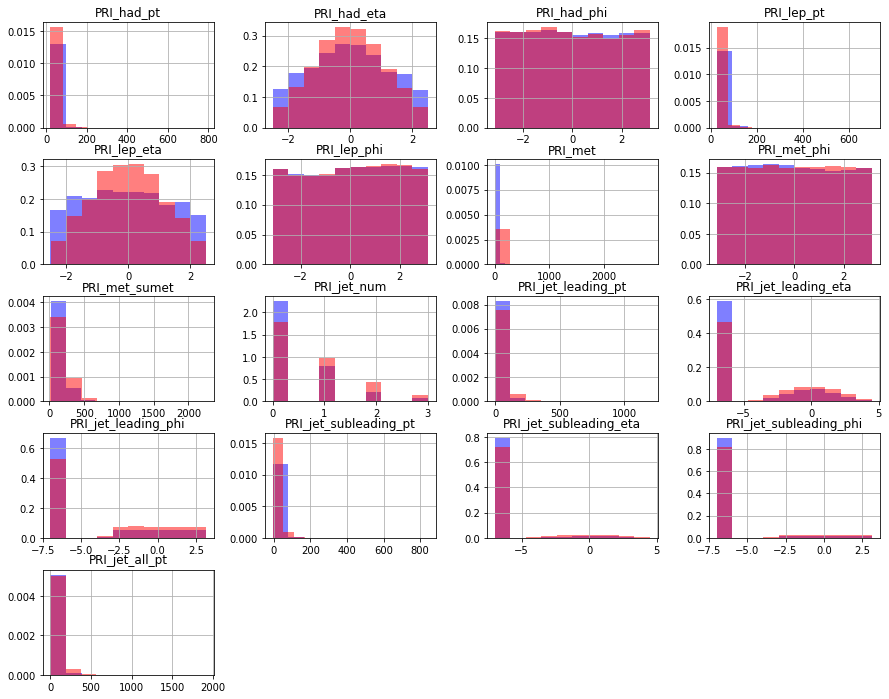

(457451, 17)


In [ ]:
import matplotlib.pyplot as plt
plt.figure()

ax=data[target==0].hist(weights=weights[target==0],figsize=(15,12),color='b',alpha=0.5,density=True)

ax=ax.flatten()[:data.shape[1]] # to avoid error if holes in the grid of plots (like if 7 or 8 features)
data[target==1].hist(weights=weights[target==1],figsize=(15,12),color='r',alpha=0.5,density=True,ax=ax)
plt.show()
print (data.shape)



#**Feature engineering**


Turn the variable "corrected" to True to work on the dataset provided by the systematic errors group. Don't forget to reexecute the code from 2 cells above when you want to come back to the original dataset.

In [ ]:
download = drive.CreateFile({'id': '1P_IEO3wxj8tSlURMDpNOZX3L65r9Gtgi'})
download.GetContentFile("atlas-higgs-challenge-2014-v2-s0_e500000.csv.gz")


  
fulldata2 = pd.read_csv("atlas-higgs-challenge-2014-v2-s0_e500000.csv.gz")

print (fulldata2.shape)
fulldata2=fulldata2.query("PRI_had_pt>22") # needed for technical reason
print (fulldata2.shape)

display(fulldata2.head())

(500000, 21)
(439494, 21)


,EventId,PRI_had_pt,PRI_had_eta,PRI_had_phi,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_met,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label,detailLabel
0,100000,32.638,1.017,0.381,51.626,2.273,-2.414,16.824,-0.277,258.733,2,67.435,2.150,0.444,46.062,1.24,-2.475,113.497,0.001333,1.0,2
1,100001,42.014,2.039,-3.011,36.918,0.501,0.103,44.704,-1.916,164.546,1,46.226,0.725,1.158,-999.000,-999.00,-999.000,46.226,1.114509,0.0,400
2,100002,32.154,-0.705,-2.093,121.409,-0.953,1.052,54.283,-2.186,260.414,1,44.251,2.053,-2.028,-999.000,-999.00,-999.000,44.251,1.171295,0.0,400
3,100003,22.647,-1.655,0.010,53.321,-0.522,-3.100,31.082,0.060,86.062,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,-0.000,2.717621,0.0,400
4,100004,28.209,-2.197,-2.231,29.774,0.798,1.569,2.723,-0.871,53.131,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,3.116281,0.0,400


In [ ]:
#remove unnecessary variable (save in separate DF just in case)
eventid = fulldata2["EventId"]
del fulldata2["EventId"]

display(fulldata2.head())

,PRI_had_pt,PRI_had_eta,PRI_had_phi,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_met,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label,detailLabel
0,32.638,1.017,0.381,51.626,2.273,-2.414,16.824,-0.277,258.733,2,67.435,2.150,0.444,46.062,1.24,-2.475,113.497,0.001333,1.0,2
1,42.014,2.039,-3.011,36.918,0.501,0.103,44.704,-1.916,164.546,1,46.226,0.725,1.158,-999.000,-999.00,-999.000,46.226,1.114509,0.0,400
2,32.154,-0.705,-2.093,121.409,-0.953,1.052,54.283,-2.186,260.414,1,44.251,2.053,-2.028,-999.000,-999.00,-999.000,44.251,1.171295,0.0,400
3,22.647,-1.655,0.010,53.321,-0.522,-3.100,31.082,0.060,86.062,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,-0.000,2.717621,0.0,400
4,28.209,-2.197,-2.231,29.774,0.798,1.569,2.723,-0.871,53.131,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,3.116281,0.0,400


In [ ]:
data = fulldata2.copy()

In [ ]:
PRI_tau_pt = data["PRI_had_pt"]

PRI_tau_eta = data["PRI_had_eta"]

PRI_tau_phi = data["PRI_had_phi"]

PRI_lep_pt = data["PRI_lep_pt"]

PRI_lep_eta = data["PRI_lep_eta"]

PRI_lep_phi = data["PRI_lep_phi"]

PRI_met = data["PRI_met"]

PRI_met_phi = data["PRI_met_phi"]

PRI_met_sumet = data["PRI_met_sumet"]

PRI_jet_num = data["PRI_jet_num"]

PRI_jet_leading_pt = data["PRI_jet_leading_pt"]

PRI_jet_leading_eta = data["PRI_jet_leading_eta"]

PRI_jet_leading_phi = data["PRI_jet_leading_phi"]

PRI_jet_subleading_pt = data["PRI_jet_subleading_pt"]

PRI_jet_subleading_eta = data["PRI_jet_subleading_eta"]

PRI_jet_subleading_phi = data["PRI_jet_subleading_phi"]

PRI_jet_all_pt = data["PRI_jet_all_pt"]

We define a few functions that will help us calculate the DERived features.

In [ ]:
def cartesian_conversion(pT, phi, eta):
  return pT*np.cos(phi), pT*np.sin(phi), pT*np.sinh(eta)
  
def modulus(pT, nu):
  return pT * np.cosh(nu)

def inv_mass(a, b):
  # a and b are vectors or arrays of vectors in cartesian coordinates
  return np.sqrt(((np.sqrt(a[0] ** 2 + a[1] ** 2 + a[2] ** 2) + np.sqrt(b[0] ** 2 + b[1] ** 2 + b[2] ** 2)) ** 2) - (a[0] + b[0]) ** 2 - (a[1] + b[1]) ** 2 - (a[2] + b[2]) ** 2)

def tr_mass(a, b):
  # a and b are vectors in cartesian coordinates
  squared_tr_mass = (np.sqrt(a[0] **2 + a[1] ** 2) + np.sqrt(b[0] **2 + b[1] **2)) ** 2 - (a[0] + b[0]) ** 2 - (a[1] + b[1]) ** 2
  if squared_tr_mass < 0:
    return 0
  return np.sqrt(squared_tr_mass)


def pseudorap_sep(nu_a, nu_b):
  return np.abs(nu_a - nu_b)


def R_sep(nu_a, nu_b, phi_a, phi_b):
  phi = phi_a - phi_b
  phi = np.abs(np.mod(phi+3*np.pi,2*np.pi)-np.pi) - np.pi # Now phi_a - phi_b is in [-pi, pi[
  return np.sqrt((nu_a - nu_b) ** 2 + phi **2)

Calculation of DER_mass_transverse_met_lep


In [ ]:
x_E = PRI_met*np.cos(PRI_met_phi) 
y_E = PRI_met*np.sin(PRI_met_phi)
x_lep = PRI_lep_pt*np.cos(PRI_lep_phi) 
y_lep = PRI_lep_pt*np.sin(PRI_lep_phi)

Emiss = []
lepton = []


for i in range(data.index[-1] + 1):
  if i in x_E.index:
    Emiss.append([x_E[i], y_E[i]])
    lepton.append([x_lep[i], y_lep[i]])

DER_mass_transverse_met_lep = []

for i in range(len(Emiss)):
  DER_mass_transverse_met_lep.append(tr_mass(np.array(Emiss[i]),np.array(lepton[i])))

DER_mass_transverse_met_lep = np.array(DER_mass_transverse_met_lep)

Calculation of DER_mass_vis

In [ ]:
p_tau = cartesian_conversion(PRI_tau_pt, PRI_tau_eta, PRI_tau_phi)
p_lep = cartesian_conversion(PRI_lep_pt, PRI_lep_eta, PRI_lep_phi)
  
DER_mass_vis = inv_mass(p_tau, p_lep)

Calculation of DER_deltaeta_jet_jet

In [ ]:
DER_deltaeta_jet_jet = pseudorap_sep(PRI_jet_leading_eta, PRI_jet_subleading_eta)
DER_deltaeta_jet_jet[PRI_jet_num <= 1] = -999

Calculation of DER_mass_jet_jet

In [ ]:
lead_cart = cartesian_conversion(PRI_jet_leading_pt, PRI_jet_leading_phi, PRI_jet_leading_eta)
sublead_cart = cartesian_conversion(PRI_jet_subleading_pt, PRI_jet_subleading_phi, PRI_jet_subleading_eta)

DER_mass_jet_jet = inv_mass(lead_cart, sublead_cart)
DER_mass_jet_jet[PRI_jet_num <= 1] = -999

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: overflow encountered in sinh
  result = getattr(ufunc, method)(*inputs, **kwargs)


Calculation of DER_lep_eta_centrality

In [ ]:
DER_lep_eta_centrality = np.exp((-4/(PRI_jet_leading_eta-PRI_jet_subleading_eta)**2)*(PRI_lep_eta-(PRI_jet_leading_eta+PRI_jet_subleading_eta)/2)**2)
DER_lep_eta_centrality[PRI_jet_num <= 1] = -999

Calculation of DER_met_phi_centrality

In [ ]:
A = np.sin(PRI_met_phi-PRI_lep_phi)*np.sign(np.sin(PRI_tau_phi-PRI_lep_phi))
B = np.sin(PRI_tau_phi-PRI_met_phi)*np.sign(np.sin(PRI_tau_phi-PRI_lep_phi))
DER_met_phi_centrality = (A+B)/np.sqrt((A**2)+(B**2))
DER_met_phi_centrality[A == -B] = 0 # Due to a strange behaviour, it returns NaN when A = -B

Calculation of DER_prodeta_jet_jet

In [ ]:
DER_prodeta_jet_jet = PRI_jet_leading_eta*PRI_jet_subleading_eta
DER_prodeta_jet_jet[PRI_jet_num <= 1] = -999

Calculation of DER_deltar_tau_lep

In [ ]:
DER_deltar_tau_lep = R_sep(PRI_tau_eta,PRI_lep_eta,PRI_tau_phi,PRI_lep_phi)

Calculation of DER_sum_pt

In [ ]:
DER_sum_pt = PRI_tau_pt+PRI_lep_pt

DER_sum_pt[PRI_jet_num == 1] += PRI_jet_leading_pt

DER_sum_pt[PRI_jet_num == 2] += PRI_jet_leading_pt+PRI_jet_subleading_pt

DER_sum_pt[PRI_jet_num == 3] += PRI_jet_all_pt


Calculation of DER_pt_ratio_lep_tau

In [ ]:
DER_pt_ratio_lep_tau = PRI_lep_pt/PRI_tau_pt

Calculation of DER_pt_h and DER_pt_tot

In [ ]:
tau_cart = np.array(cartesian_conversion(PRI_tau_pt, PRI_tau_phi, PRI_tau_eta))
lep_cart = np.array(cartesian_conversion(PRI_lep_pt, PRI_lep_phi, PRI_lep_eta))
met_cart = np.array(cartesian_conversion(PRI_met, PRI_met_phi, 0)) # Only the two first terms are useful
lead_cart = cartesian_conversion(PRI_jet_leading_pt, PRI_jet_leading_phi, PRI_jet_leading_eta)
sublead_cart = cartesian_conversion(PRI_jet_subleading_pt, PRI_jet_subleading_phi, PRI_jet_subleading_eta)

sum_vector = np.transpose(tau_cart + lep_cart + met_cart)

DER_pt_h = np.sqrt(sum_vector[:, 0] ** 2 + sum_vector[:, 1] ** 2)


# Now we add the two jets
lead_cart = np.transpose(np.array(lead_cart))
sublead_cart = np.transpose(np.array(sublead_cart))
tests = np.array(PRI_jet_num)

for i in range(data.shape[0]):
  if tests[i] >= 1:
    sum_vector[i] += lead_cart[i]
  if tests[i] >= 2:
    sum_vector[i] += sublead_cart[i]


DER_pt_tot = np.sqrt(sum_vector[:, 0] ** 2 + sum_vector[:, 1] ** 2)

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: overflow encountered in sinh
  result = getattr(ufunc, method)(*inputs, **kwargs)


We now add the DERived features to our data tables

In [ ]:
data = data.assign(DER_mass_transverse_met_lep = DER_mass_transverse_met_lep)
data = data.assign(DER_mass_vis = DER_mass_vis)
data = data.assign(DER_pt_h = DER_pt_h)
data = data.assign(DER_deltaeta_jet_jet = DER_deltaeta_jet_jet)
data = data.assign(DER_mass_jet_jet = DER_mass_jet_jet)
data = data.assign(DER_prodeta_jet_jet = DER_prodeta_jet_jet)
data = data.assign(DER_deltar_tau_lep = DER_deltar_tau_lep)
data = data.assign(DER_pt_tot = DER_pt_tot)
data = data.assign(DER_sum_pt = DER_sum_pt)
data = data.assign(DER_pt_ratio_lep_tau = DER_pt_ratio_lep_tau)
data = data.assign(DER_met_phi_centrality = DER_met_phi_centrality)
data = data.assign(DER_lep_eta_centrality = DER_lep_eta_centrality)

print(data.shape)
data.replace(-7,-999,inplace=True)

data.head()


(439494, 32)


,PRI_had_pt,PRI_had_eta,PRI_had_phi,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_met,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label,detailLabel,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_tau,DER_met_phi_centrality,DER_lep_eta_centrality
0,32.638,1.017,0.381,51.626,2.273,-2.414,16.824,-0.277,258.733,2,67.435,2.150,0.444,46.062,1.24,-2.475,113.497,0.001333,1.0,2,51.661920,163.187301,27.947400,0.91,122.581441,2.666,1.302944,41.911618,197.761,1.581776,1.396522,0.199142
1,42.014,2.039,-3.011,36.918,0.501,0.103,44.704,-1.916,164.546,1,46.226,0.725,1.158,-999.000,-999.00,-999.000,46.226,1.114509,0.0,400,68.783298,186.770557,48.122970,-999.00,-999.000000,-999.000,1.538247,2.063284,125.158,0.878707,1.414180,-999.000000
2,32.154,-0.705,-2.093,121.409,-0.953,1.052,54.283,-2.186,260.414,1,44.251,2.053,-2.028,-999.000,-999.00,-999.000,44.251,1.171295,0.0,400,162.174512,288.520441,35.625939,-999.00,-999.000000,-999.000,0.248023,9.316181,197.814,3.775860,1.413986,-999.000000
3,22.647,-1.655,0.010,53.321,-0.522,-3.100,31.082,0.060,86.062,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,-0.000,2.717621,0.0,400,81.417024,161.569652,0.416824,-999.00,-999.000000,-999.000,1.133440,0.416824,75.968,2.354440,-1.283975,-999.000000
4,28.209,-2.197,-2.231,29.774,0.798,1.569,2.723,-0.871,53.131,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,3.116281,0.0,400,16.911571,198.052652,16.409958,-999.00,-999.000000,-999.000,3.066517,16.409958,57.983,1.055479,-1.385461,-999.000000


Now we extract the dataset into a csv file if turned to True

In [ ]:
if False:
  data.to_csv("./data_derived_variables_corrected.csv")

Here we plot histograms for the derived variables showing what PDFs look like for both signal and background. It could give clues to what derived feature will be important to train the AI

<Figure size 432x288 with 0 Axes>

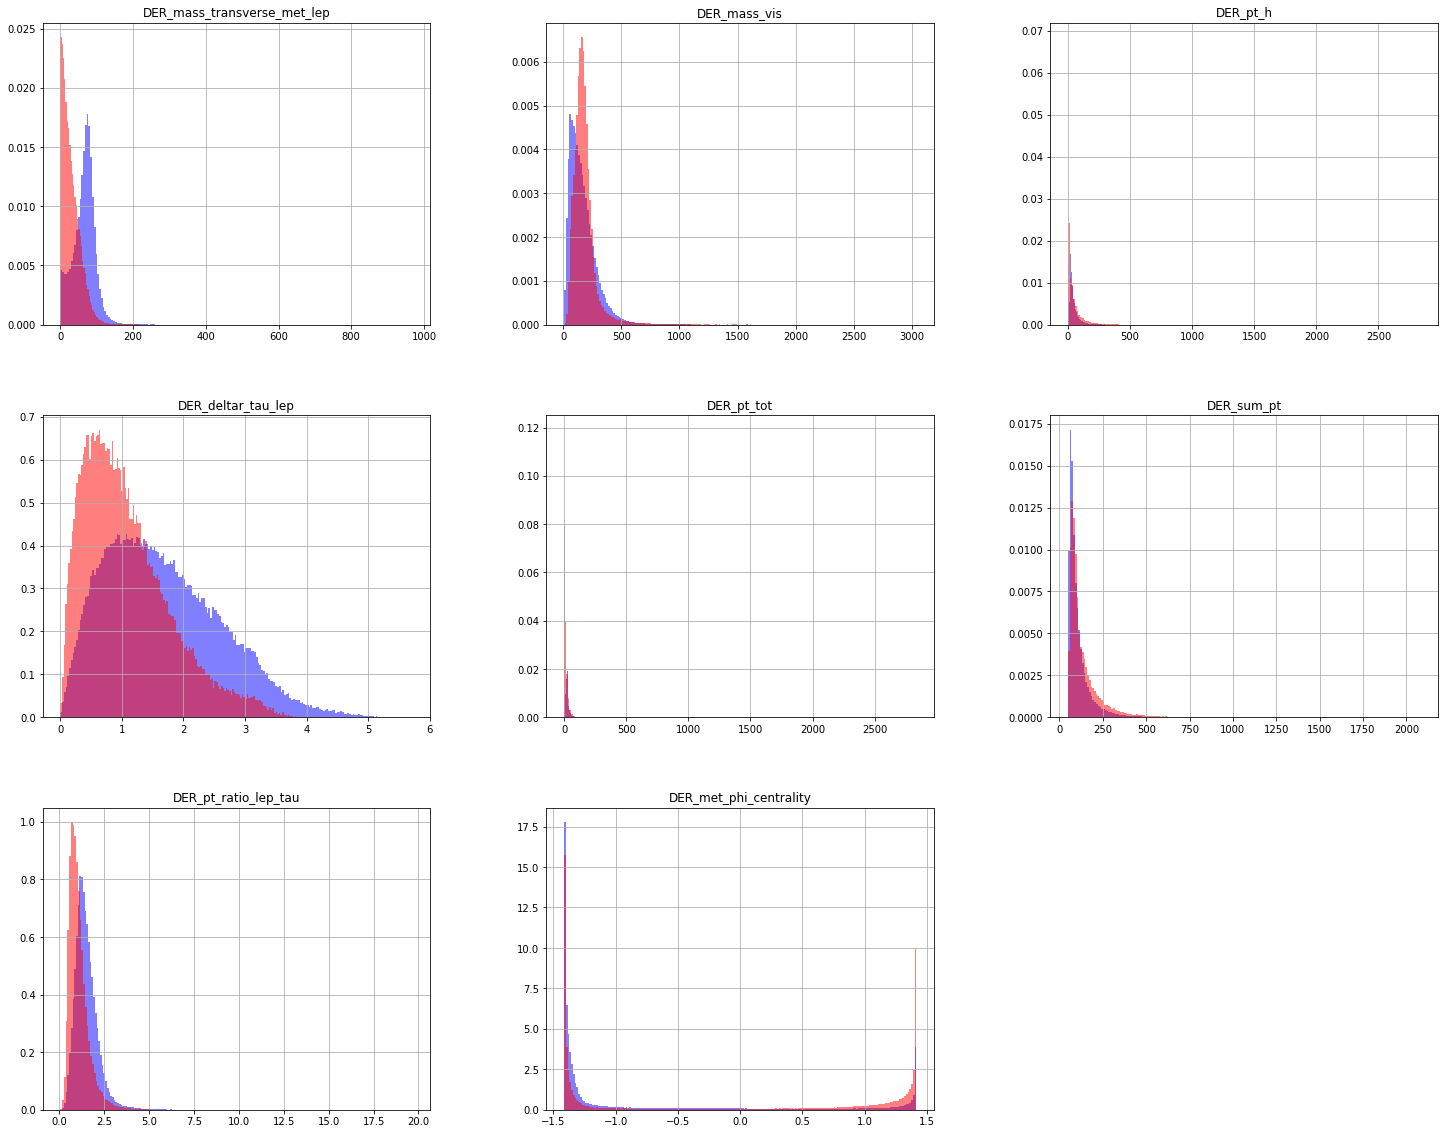

<Figure size 432x288 with 0 Axes>

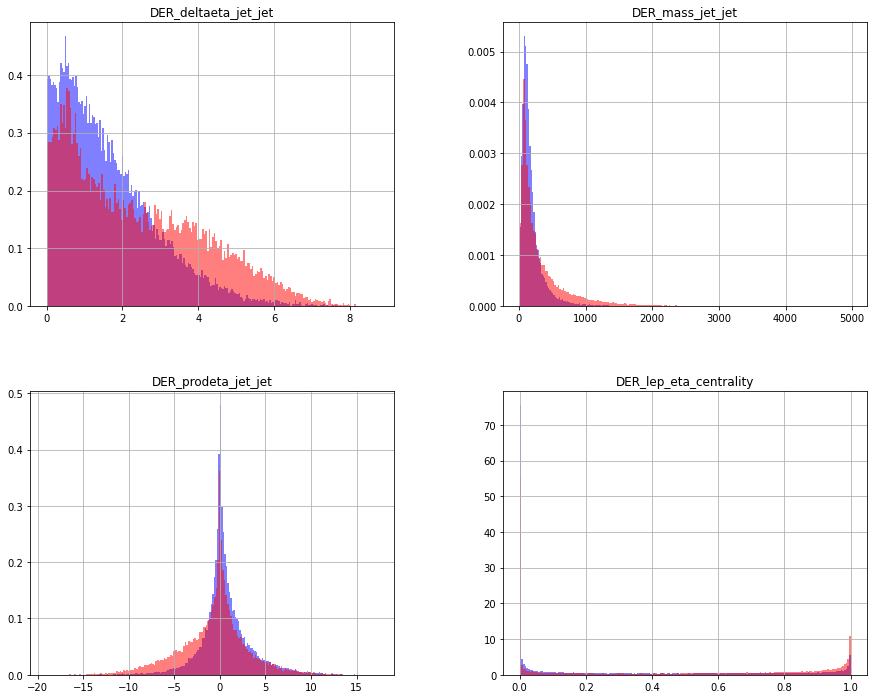

Number of values in the whole dataset : 439494
Number of values defined for all the variables : 132218
Ratio : 0.30084142218096266


In [ ]:
frame = {'DER_mass_transverse_met_lep': DER_mass_transverse_met_lep, 
        'DER_mass_vis' : DER_mass_vis,
        'DER_pt_h' : DER_pt_h,
        'DER_deltaeta_jet_jet' : DER_deltaeta_jet_jet,
        'DER_mass_jet_jet' : DER_mass_jet_jet,
        'DER_prodeta_jet_jet' : DER_prodeta_jet_jet,
        'DER_deltar_tau_lep' : DER_deltar_tau_lep,
        'DER_pt_tot' : DER_pt_tot,
        'DER_sum_pt' : DER_sum_pt,
        'DER_pt_ratio_lep_tau' : DER_pt_ratio_lep_tau,
        'DER_met_phi_centrality' : DER_met_phi_centrality,
        'DER_lep_eta_centrality' : DER_lep_eta_centrality}

data_to_plot = pd.DataFrame(frame).reset_index() # Because there is an event selection, indexes are not full, leading to strange behaviour

del data_to_plot["index"] # reset_index() adds an unwanted column 'index'

target = data["Label"]
weights = data["Weight"]

target = target.reset_index()["Label"]
weights = weights.reset_index()["Weight"]

# We separate the dataset so that the histograms only show defined values
to_plot_all = data_to_plot[['DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality']]
to_plot_jet = data_to_plot[['DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_lep_eta_centrality']][data_to_plot['DER_deltaeta_jet_jet'] != -999]

plt.figure()

ax=to_plot_all[target==0].hist(weights=weights[target==0],figsize=(25,20),color='b',alpha=0.5,density=True, bins = 200)

ax=ax.flatten()[:to_plot_all.shape[1]] # to avoid error if holes in the grid of plots (like if 7 or 8 features)
to_plot_all[target==1].hist(weights=weights[target==1],figsize=(25,20),color='r',alpha=0.5,density=True,ax=ax, bins = 200)

plt.show()

target = target[data_to_plot['DER_deltaeta_jet_jet'] != -999]
weights = weights[data_to_plot['DER_deltaeta_jet_jet'] != -999]

plt.figure()

ax=to_plot_jet[target==0].hist(weights=weights[target==0],figsize=(15,12),color='b',alpha=0.5,density=True, bins = 200)

ax=ax.flatten()[:to_plot_jet.shape[1]] # to avoid error if holes in the grid of plots (like if 7 or 8 features)
to_plot_jet[target==1].hist(weights=weights[target==1],figsize=(15,12),color='r',alpha=0.5,density=True,ax=ax, bins = 200)

plt.show()

# Now we calculate the proportion of values that are defined for all the variables

all_values = to_plot_all.shape[0]
defined_values = to_plot_jet.shape[0]

print("Number of values in the whole dataset :", all_values)
print("Number of values defined for all the variables :", defined_values)
print("Ratio :", defined_values/all_values)

## Boost Decision Tree

### *Récupération du modèle entraîné de BDT*




In [ ]:

!pip install xgboost --upgrade 
pass

import xgboost
print(xgboost.__version__)


     |████████████████████████████████| 166.7MB 52kB/s 
  Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90
1.4.2


Import du dataset

In [ ]:
link = 'https://drive.google.com/file/d/179JAvqA15laThDLo6o23PK5XyuMUr0ld/view?usp=sharing'
import pandas as pd
  
# to get the id part of the file
id = "1rh0b9VNOlSpM223XxW-CBJwrGHYikkTE"
  
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('data.csv',)  
  
fulldata = pd.read_csv('data.csv')
del fulldata["Unnamed: 0"]
fulldata.dropna(inplace=True)
fulldata.describe()

,EventId,PRI_had_pt,PRI_had_eta,PRI_had_phi,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_met,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label,detailLabel,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_tau,DER_met_phi_centrality,DER_lep_eta_centrality
count,457377.000000,457377.000000,457377.000000,457377.000000,457377.000000,457377.000000,457377.000000,457377.000000,457377.000000,457377.00000,457377.000000,457377.000000,457377.000000,457377.000000,457377.000000,457377.000000,457377.000000,457377.000000,457377.000000,457377.000000,457377.000000,457377.000000,457377.000000,457377.000000,457377.000000,457377.000000,457377.000000,457377.000000,457377.000000,457377.000000,457377.000000,457377.000000,4.573770e+05
mean,349979.338989,41.603830,-0.013807,-0.013147,46.749935,-0.020504,0.047300,43.111114,-0.007869,217.14240,0.996854,-337.675093,-391.483797,-391.491496,-683.927646,-701.691551,-701.693265,77.310865,0.821019,0.360963,194.724757,47.952555,173.194696,61.306084,-700.969230,-586.875499,-701.946412,1.549001,20.073113,165.664630,1.325686,-0.087703,-7.015521e+02
std,144326.419486,23.430475,1.205169,1.816219,22.224089,1.257886,1.814577,34.402008,1.811273,131.09718,0.981240,533.170717,487.681450,487.675345,484.385836,456.747958,456.745048,102.643194,0.955725,0.480280,178.303077,35.496665,144.302956,66.259420,457.857279,672.081096,456.359277,0.884814,21.808589,120.765391,0.767922,1.198413,4.569608e+02
min,100000.000000,22.001000,-2.499000,-3.142000,26.000000,-2.508000,-3.142000,0.027000,-3.142000,14.75900,0.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0.000000,0.000754,0.000000,0.000000,0.000000,6.462390,0.012608,-999.000000,-999.000000,-999.000000,0.002557,0.012608,48.076000,0.046028,-1.414214,-9.990000e+02
25%,225033.000000,26.905000,-0.917000,-1.583000,32.342000,-1.003000,-1.515000,21.713000,-1.573000,127.36000,0.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0.000000,0.009362,0.000000,1.000000,18.086592,82.228127,15.475440,-999.000000,-999.000000,-999.000000,0.849758,4.880599,81.026000,0.824483,-1.371477,-9.990000e+02
50%,349963.000000,34.454000,-0.026000,-0.041000,40.528000,-0.045000,0.091000,35.538000,-0.018000,185.84400,1.000000,41.112000,-1.796000,-2.037000,-999.000000,-999.000000,-999.000000,43.077000,0.584746,0.000000,123.000000,44.049738,136.572850,40.562216,-999.000000,-999.000000,-999.000000,1.420747,13.319084,126.613000,1.179120,-0.195204,-9.990000e+02
75%,474940.000000,48.009000,0.887000,1.560000,53.548000,0.947000,1.616000,53.791000,1.558000,272.65500,2.000000,79.417000,0.458000,0.530000,35.475000,-2.282000,-2.149000,116.770000,1.200200,1.000000,400.000000,72.319903,215.287823,83.627458,0.563000,88.524873,-4.211466,2.140964,28.320318,210.044000,1.633480,1.248308,4.294931e-07
max,599999.000000,787.340000,2.499000,3.142000,701.328000,2.506000,3.142000,2843.646000,3.142000,2248.34900,3.000000,1198.342000,4.499000,3.142000,842.335000,4.500000,3.142000,1915.980000,4.095734,1.000000,400.000000,968.958141,3084.002651,2835.955769,8.724000,5125.017256,17.293560,5.718588,2835.955769,2140.006000,31.289730,1.414214,1.000000e+00


Load X_test and X_train

Load test sample event ids

In [ ]:
import pickle

link = "https://drive.google.com/file/d/1t_51v8L1dXM85dEGR7Ojz8HX33aozvUX/view?usp=sharing"

id = link.split("/")[-2]

downloaded = drive.CreateFile({"id": id})
downloaded.GetContentFile('test_ids.p')
test_ids = pickle.load(open("test_ids.p","rb"))

Select the data to predict (corresponding to the event id of the test dataset

In [ ]:
dataset = fulldata.copy()

test_dataset = dataset.loc[dataset['EventId'].isin(test_ids)]
eventId_test = test_dataset["EventId"]
del test_dataset["EventId"]
label_test = test_dataset["Label"]
del test_dataset["Label"]
weight_test = test_dataset["Weight"]
del test_dataset["Weight"]
del test_dataset["detailLabel"]
X_test = test_dataset.copy()
print(X_test.shape)



train_dataset = dataset.loc[~dataset['EventId'].isin(test_ids)]
eventId_train = train_dataset["EventId"]
del train_dataset["EventId"]
label_train = train_dataset["Label"]
del train_dataset["Label"]
weight_train = train_dataset["Weight"]
del train_dataset["Weight"]
del train_dataset["detailLabel"]
X_train = train_dataset.copy()



y_test, y_train = label_test.copy(), label_train.copy()
weights_test, weights_train = weight_test.copy(), weight_train.copy()

train_size = X_train.size/(X_train.size + X_test.size)

y_train_2, y_test_2, weights_train_2, weights_test_2 = \
    y_train.reset_index(drop=True), y_test.reset_index(drop=True), \
    weights_train.reset_index(drop=True), weights_test.reset_index(drop=True)

class_weights_train = (weights_train_2[y_train_2==0].sum(), weights_train_2[y_train_2==1].sum())

for i in range(len(class_weights_train)):
  weights_train_2[y_train_2==i] *= max(class_weights_train)/class_weights_train[i]
  weights_test_2[y_train_2==i] *= 1/(1-train_size)

(91476, 29)


Load xgboost module 

### Compute XGBoost predictions

In [ ]:
from sklearn.preprocessing import StandardScaler

#scale to mean 0 and variance 1

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) 

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve


# Lien Drive du modèle BDT
link = "https://drive.google.com/file/d/1C2fJ7tx-7ZlnO9eFxmQ3HGzjJ35uUiFE/view?usp=sharing"
id3 = link.split("/")[-2]

downloaded = drive.CreateFile({"id": id3})
downloaded.GetContentFile('XGBoost.model')


# récuperer le jeu de Test sur Drive
xgb = XGBClassifier(tree_method="hist",use_label_encoder=False,eval_metric='logloss', learning_rate=0.12, max_depth=8, n_estimators=99)
xgb.load_model("XGBoost.model")

y_pred_xgb = xgb.predict_proba(X_test_scaled)[:,1].ravel()
y_pred_train_xgb = xgb.predict_proba(X_train_scaled)[:,1].ravel()




In [ ]:
pred = pd.DataFrame({"Prediction": y_pred_xgb})
pred

,Prediction
0,0.082915
1,0.065633
2,0.738462
3,0.618912
4,0.961573
...,...
91471,0.129801
91472,0.005752
91473,0.030780
91474,0.213647


In [ ]:
# A modifier

result = pd.concat([eventId_test.reset_index(), label_test.reset_index(), weight_test.reset_index(), pred], axis= 1)
del result["index"]
result

,EventId,Label,Weight,Prediction
0,100003,0.0,2.853502,0.082915
1,100004,0.0,3.272095,0.065633
2,100005,0.0,0.043703,0.738462
3,100021,0.0,0.881041,0.618912
4,100023,1.0,0.000755,0.961573
...,...,...,...,...
91471,599961,0.0,0.994969,0.129801
91472,599966,0.0,1.013057,0.005752
91473,599967,0.0,1.370538,0.030780
91474,599970,1.0,0.000755,0.213647


ROC and significance curves

Load significance function

In [ ]:
from math import sqrt
from math import log
def amsasimov(s,b): # asimov significance arXiv:1007.1727 eq. 97
        if b<=0 or s<=0:
            return 0
        try:
            return sqrt(2*((s+b)*log(1+float(s)/b)-s))
        except ValueError:
            print(1+float(s)/b)
            print(2*((s+b)*log(1+float(s)/b)-s))
        #return s/sqrt(s+b)

In [ ]:
from sklearn.metrics import roc_auc_score
auc_test_xgb = roc_auc_score(y_true=y_test_2, y_score=y_pred_xgb, sample_weight=weights_test_2)
auc_train_xgb = roc_auc_score(y_true=y_train.values, y_score=y_pred_train_xgb)
print("auc test:", auc_test_xgb)
print("auc train:", auc_train_xgb)


auc test: 0.9258660496120164
auc train: 0.8774211785865328


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

int_pred_test_sig_xgb = [weights_test_2[(y_test_2 ==1) & (y_pred_xgb > th_cut)].sum() for th_cut in np.linspace(0,1,num=50)]
int_pred_test_bkg_xgb = [weights_test_2[(y_test_2 ==0) & (y_pred_xgb > th_cut)].sum() for th_cut in np.linspace(0,1,num=50)]

vamsasimov_xgb = [amsasimov(sumsig,sumbkg) for (sumsig,sumbkg) in zip(int_pred_test_sig_xgb,int_pred_test_bkg_xgb)]
significance_xgb = max(vamsasimov_xgb)
Z = significance_xgb
print("Z:",Z)

Z: 3.177381422053353


Plot ROC curve

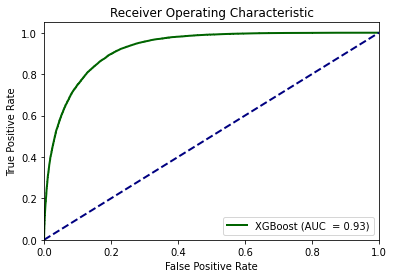

In [ ]:
from sklearn.metrics import roc_curve
lw = 2

fpr_xgb,tpr_xgb,_ = roc_curve(y_true=y_test_2, y_score=y_pred_xgb,sample_weight=weights_test_2.values)
plt.plot(fpr_xgb, tpr_xgb, color='darkgreen',lw=lw, label='XGBoost (AUC  = {})'.format(np.round(auc_test_xgb,decimals=2)))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

#plt.savefig(drive_path + "ROC_comparing_" + version + ".pdf")
plt.show() 

Plot significance curve

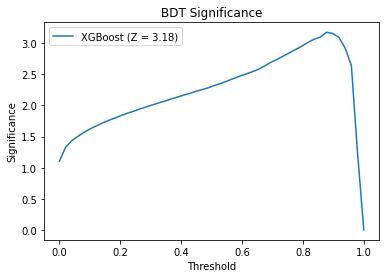

In [ ]:

plt.plot(np.linspace(0,1,num=50),vamsasimov_xgb, label='XGBoost (Z = {})'.format(np.round(significance_xgb,decimals=2)))

plt.title("BDT Significance")
plt.xlabel("Threshold")
plt.ylabel("Significance")
plt.legend()
#plt.savefig(drive_path + "Significance_comparing_" + version + ".pdf")
plt.show()

## NeuralNetworks

# Machine Learning : Neural Networks & Boosted Decision Tree

In [150]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.utils import class_weight
import json
import pickle

pipeline_NN = False

if pipeline_NN :
# Function that loads the model and the associated test_ids
  def load_model(path_json,path_h5,test_ids_path=None):
      with open(path_json, 'r') as json_file:
          architecture = json.load(json_file)
          model = tf.keras.models.model_from_json(json.dumps(architecture))
      model.load_weights(path_h5)
      if test_ids_path is None:
          test_ids = None
      else:
          test_ids = pickle.load(open(test_ids_path, "rb"))
      print('Model loaded successfully !')
      return (model,test_ids)

# Function to split the dataset according to test_ids
  def split_dataset(data, test_ids, return_train=False):
      test_dataset = data.loc[data['EventId'].isin(test_ids)]
      y_test = test_dataset['Label']
      del test_dataset["Label"]
      weights_test = test_dataset["Weight"]
      del test_dataset["Weight"]
      del test_dataset["detailLabel"]
      del test_dataset["Unnamed: 0"]
      del test_dataset["EventId"]
      X_test = test_dataset.copy()

      if return_train:
          train_dataset = data.loc[~data['EventId'].isin(test_ids)]
          y_train = train_dataset['Label']
          del train_dataset["Label"]
          weights_train = train_dataset["Weight"]
          del train_dataset["Weight"]
          del train_dataset["detailLabel"]
          del train_dataset["Unnamed: 0"]
          del train_dataset["EventId"]
          X_train = train_dataset.copy()

      print('Dataset split successfully !')
      if return_train:
          return (X_train, weights_train, y_train, X_test, weights_test, y_test)
      else:
          return (X_test, weights_test, y_test)

# Lien Drive du modèle
  if not os.path.exists('model'):
      download = drive.CreateFile({'id': '1Hfns7qYkzwQkfj3IbEh6P-Ew9pgKDNfE'})
      download.GetContentFile("model.zip")
      !unzip "model.zip" -d "./"
      os.remove("model.zip")

  model,test_ids = load_model('./model/model.json','./model/model.h5','./model/test_ids.p')

  if pipeline_NN:
    X_test, weights_test, y_test, X_train, weights_train, y_train = split_dataset(data,test_ids, True)

    y_pred = model.predict(X_test)
    df_pred = pd.DataFrame(y_pred)
    df_pred

    result = pd.concat([y_test,weights_test,df_pred],axis=1)
    result.columns = ['Label','Weight','Score']



In [151]:
if pipeline_NN :

  from math import sqrt
  from math import log
  import matplotlib.pyplot as plt
  def amsasimov(s,b): # asimov (or Poisson) significance
          if b<=0 or s<=0:
              return 0
          try:
              return sqrt(2*((s+b)*log(1+float(s)/b)-s))
          except ValueError:
              print(1+float(s)/b)
              print (2*((s+b)*log(1+float(s)/b)-s))
        #return s/sqrt(s+b)

In [152]:
if pipeline_NN :
  y_test = label_test
  y_train = label_train
  model.compile(loss="binary_crossentropy", optimizer='adam', metrics = ["binary_accuracy"])
  score = model.evaluate(X_test,y_test, verbose = 1)

  from sklean.metrics import roc_curve, roc_auc_score
  loss,accuracy = score[0],score[1]
  print("binary loss :", loss)
  print("binary accuracy :",accuracy)

  y_pred_test = model.predict(X_test).ravel()
  y_pred_train = model.predict(X_train).ravel()
  auc_test = roc_auc_score(y_true=y_test, y_score=y_pred_test)
  auc_train = roc_auc_score(y_true=y_train.values, y_score=y_pred_train)
  print("auc test:",auc_test)
  print ("auc train:",auc_train)
  int_pred_test_sig = [weight_test[(y_test ==1) & (y_pred_test > th_cut)].sum() for th_cut in np.linspace(0,1,num=50)]
  int_pred_test_bkg = [weight_test[(y_test ==0) & (y_pred_test > th_cut)].sum() for th_cut in np.linspace(0,1,num=50)]

  lw = 2

  fpr,tpr,_ = roc_curve(y_true=y_test, y_score=y_pred_test,sample_weight=weight_test.values)
  plt.plot(fpr, tpr, color='darkorange',lw=lw, label='NN (AUC  = {})'.format(np.round(auc_test,decimals=2)))
  plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic')
  plt.legend(loc="lower right")
  plt.show()

  vamsasimov = [amsasimov(sumsig,sumbkg) for (sumsig,sumbkg) in zip(int_pred_test_sig,int_pred_test_bkg)]
  plt.plot(np.linspace(0,1,len(vamsasimov)),vamsasimov)
  Z = max(vamsasimov)
  print("Z:",Z)

### Statistical Treatments

# Statistical treatment

The model we will be using is the following: the detector recieves $n=\mu S+B$ events, with $S$ the predicted number of signal events, $B$ the predicted number of background events, and $\mu$ the signal strength, which we aim at identifying.

More accurately, we aim at determining $\sigma_\mu$, the uncertainty on the maximum likelihood estimator of $\mu$, given the actual number of signal and background events. 

Let's start with importing the useful libraries.

In [ ]:
from matplotlib import pyplot as plt
from scipy import stats
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import set_matplotlib_formats, display
from scipy.stats import poisson, norm
from scipy.optimize import minimize
import matplotlib.colors as colors

set_matplotlib_formats('pdf', 'svg')
%config InlineBackend.figure_format ='svg'
plt.style.use('ggplot')

# Definition of the progress bar
def progressbar(value, max=100):
  from IPython.display import HTML
  return HTML("""<progress value='{value}' max='{max}' style='width: 100%'>
    {value}</progress>""".format(value=value, max=max))
  
def pbinit(kmin, kmax):
  return display(progressbar(kmin, kmax), display_id=True)

# Definition of LaTex format printing functions:
def pprint(mu, sigma_plus, sigma_minus):
  from IPython.display import display, Latex
  display(Latex(r'$\hat{\mu} = ' +
                f'{mu:.3f}' +
                r'^{+' + f'{sigma_plus:.3f}' + r'}' +
                r'_{-' + f'{sigma_minus:.3f}' + r'}$'))
  
def pprintMC(mu, sigma_plus, sigma_minus):
  from IPython.display import display, Latex
  display(Latex(r'$\hat{\mu}_{MC} = ' +
                f'{mu:.3f}' +
                r'^{+' + f'{sigma_plus:.3f}' + r'}' +
                r'_{-' + f'{sigma_minus:.3f}' + r'}$'))



Now that the libraries are imported, we may define our model, as well as the probability density functions for signal and background events with respect to their score from the Neural Network and Boosted Decision Tree algorithms.

In [ ]:
isNN = False;

linkBDT = 'https://drive.google.com/file/d/1hjJHSanUs6pzodxhkkKN24I_VZK4eSLo/view?usp=sharing'
  
# to get the id part of the file
idStat = linkBDT
  
downloaded = drive.CreateFile({'id': idStat}) 
downloaded.GetContentFile('tableau_BDT.csv',) 

#Neural Nets

linkNN = 'https://drive.google.com/file/d/1GTk2t33fsUJxAyh2ou89POSIELbflevR/view?usp=sharing'
  
# to get the id part of the file
idNN = linkNN.split("/")[-2]
  
downloaded = drive.CreateFile({'id':idNN}) 
downloaded.GetContentFile('tableau_NN.csv',) 

#si on prend le jeu de données issus du training de NeuralNetworks

ApiRequestError: ignored

In [ ]:
isNN = False

In [ ]:
# Loading the data obtained by NN and BDT

if isNN:
  
  
  tab=pd.read_csv('tableau_NN.csv', delimiter=',')
  events_list= eventId_test.tolist()
  #score label weight
  # events_list=[[events_list[i][3],events_list[i][1],events_list[i][2]] for i in range (len(events_list))]
  result = pd.concat([eventId_test, label_test, weight_test, pred])
  good_result = pd.concat([pred, label_test, weight_test])
  events_list = good_result.values.tolist()

else:
  tab=pd.read_csv('tableau_BDT.csv', delimiter=',')
  #tab=pd.read_csv('X_test_score_label_weight_PRI_DER.csv', delimiter=',')
  events_list=tab.values.tolist()
  #score label weight
  events_list=[[events_list[i][3],events_list[i][1],events_list[i][2]] for i in range (len(events_list))]


# Definition of the empirical probability density functions for the signal and background
def diagram(l,dt):
  x = np.arange(0,1+dt,dt)
  count_signal = [0]*len(x)
  count_bruit = [0]*len(x)
  nb_signal = 0
  nb_bruit = 0
  weight_signal = 0
  weight_bruit = 0
  for e in l:
    for k in range(1,len(x)):
      if x[k]>e[0] and x[k-1]<=e[0]:
        if e[1]==0:
          count_bruit[k-1]+= e[2]
          weight_bruit += e[2]
          nb_bruit += 1
        else:
          count_signal[k-1]+= e[2]
          weight_signal += e[2]
          nb_signal += 1
  print(weight_bruit,weight_signal)
  cs = [i/weight_signal for i in count_signal]
  cb =  [i/weight_bruit for i in count_bruit]
  return np.array(cs),np.array(cb),weight_signal,weight_bruit

dt = 0.05
pS,pB,S,B = diagram(events_list,dt)
S,B = round(S), round(B)

n = S+B

# Definition of the parametric model
def model(mu):
  return mu*S + B

329037.54309081845 661.9422389424745


## Counting analysis

Our first approach will consist in couting the total number of signal events and of background events, regardless of their score.

Given our definition of $n:=S+B$, we expect $\hat{\mu}$, the maximum likelihood estimator for $\mu$, to be equal to $1$. Nonetheless, we may determine the uncertainty $\sigma_\mu$ on that value.

To do so, we use the following approximation:
$$-2\,\log\left(\frac{{\cal L}(\mu)} {{\cal L}(\hat{\mu})}\right)\approx\left(\frac{\mu-\hat{\mu}}{\sigma_{\mu}}\right)^2,$$
and notice that, for $\mu=\hat{\mu}\pm\sigma_\mu$, it holds: $\left(\frac{\mu-\hat{\mu}}{\sigma_{\mu}}\right)^2=1$.

All in all, if $\mu_-\leq\mu_+$ are such that:
$$-2\,\log\left(\frac{{\cal L}(\mu_\pm)} {{\cal L}(\hat{\mu})}\right)=1,$$
then we can estimate $\sigma_\mu\approx\frac{\mu_+-\mu_-}{2}$.


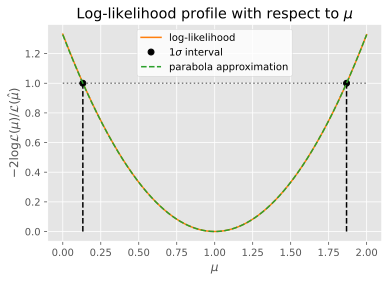

{Counting analysis} Best fit parameter and uncertainty:



<IPython.core.display.Latex object>

In [ ]:
# Definition of the log-likelihood
def loglik(mu, n):
  return -2*np.log(poisson.pmf(n, model(mu)))

# Disretization of mu values and associated log-likelihood
mu_axis_values = np.linspace(0, 2, 1000)
loglike_values = np.array([loglik(mu, n) for mu in mu_axis_values])

plt.plot(mu_axis_values, loglike_values - min(loglike_values), color = 'tab:orange', label='log-likelihood')
plt.hlines(1, min(mu_axis_values), max(mu_axis_values), linestyle= ':', color= 'tab:gray')

# Determination of mu- and mu+:
idx = np.argwhere(np.diff(np.sign(loglike_values-min(loglike_values)-1))).flatten()

# Plot of the mu values:
plt.plot(mu_axis_values[idx], [1, 1], 'ko', label=r'$1\sigma$ interval')
plt.plot(mu_axis_values[idx[0]]*np.ones(2), [0, 1], 'k--')
plt.plot(mu_axis_values[idx[1]]*np.ones(2), [0, 1], 'k--')
plt.xlabel(r'$\mu$')
plt.ylabel(r'$-2\log {\cal L}(\mu)/{\cal L}(\hat{\mu})$')
plt.title(r'Log-likelihood profile with respect to $\mu$')

# Computation of sigma_mu
sigma_mu = np.diff(mu_axis_values[idx])/2

plt.plot(mu_axis_values, ((mu_axis_values-1)/sigma_mu)**2, linestyle='--',
         color= 'tab:green', label='parabola approximation')
plt.legend(facecolor = 'w')
plt.show()

# Determination of mu_hat for the discretization
muhat = mu_axis_values[np.argmin(loglike_values)]

print('{Counting analysis} Best fit parameter and uncertainty:\n')
pprint(muhat, mu_axis_values[idx[1]] - muhat, abs(mu_axis_values[idx[0]] - muhat))

One could also use the Monte-Carlo method to determine the average $\hat{\mu}$ and the associated uncertainty $\sigma_\mu$.

## Binned shape analysis

In order to get a better result, we implement the binned shape analysis method. Instead of counting all the signal and background events, we count them depending on their score. Then, we define the likelihood on each score interval (bin), and compute $\hat{\mu}$ with that new composite likelihood. To do so, we use the probability density functions of $S$ and $B$.

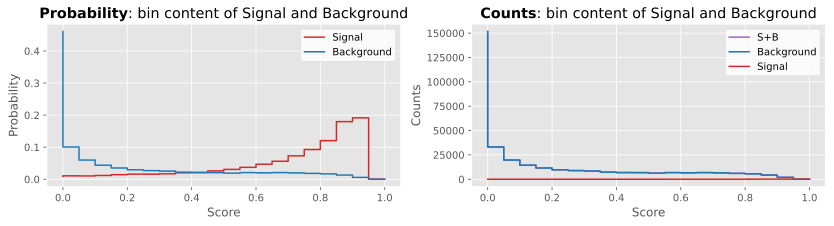

In [ ]:
# And we draw the result of the bin contents:
fig, fig_axes = plt.subplots(ncols=2, nrows=1)
fig.set_size_inches(w=14, h=3)
x_bin_edges = np.arange(0,1+dt,dt)

fig_axes[0].step(x_bin_edges, pS, color= 'tab:red', label='Signal')
fig_axes[0].step(x_bin_edges, pB, color = 'tab:blue', label='Background')
fig_axes[0].set_title(r'${\bf Probability}$: bin content of Signal and Background')
fig_axes[0].set_xlabel('Score')
fig_axes[0].set_ylabel('Probability')
fig_axes[0].legend(facecolor= 'w')

fig_axes[1].step(x_bin_edges, S*pS+B*pB, color = 'tab:purple', label='S+B')
fig_axes[1].step(x_bin_edges, B*pB, color = 'tab:blue', label='Background')
fig_axes[1].step(x_bin_edges, S*pS, color = 'tab:red', label='Signal')
fig_axes[1].set_title(r'${\bf Counts}$: bin content of Signal and Background')
fig_axes[1].set_xlabel('Score')
fig_axes[1].set_ylabel('Counts')
fig_axes[1].legend(facecolor= 'w')

plt.show()

Now our PDF is discretized on the bins, we can compute the likelihood for $\mu$ values on each bin, and determine the maximum likelihood estimator $\hat{\mu}$ by optimizing the global log-likelihood.

In [ ]:
# Expected number of events in the bins (rounded to be used with a Poisson distribution) 
y = np.round(S*pS + B*pB) 

# Actual bin content
def BinContent(k, mu):
  return mu*S*pS[k]+B*pB[k]

# Definition of the likelihood for each bin
def likp(k, yk, mu):
  return poisson(BinContent(k, mu)).pmf(yk)

# Computation of the global log-likelihood
def bll(mu):
  return -2*sum([np.log(likp(k, y[k], mu)) for k in range(0,np.size(y))])

EPS = 0.0001 # trick to avoid potential division by zero during the minimization
par_bnds = ((EPS, None)) # Forbids parameter values to be negative, so mu>EPS here.
par0 = 0.9 # quick bad guess to start with some value of mu...
res = minimize(bll, par0, bounds= par_bnds[1], method='Nelder-Mead')

if not res.success:
  print("minimize n'a pas convergé")
print(f'mu = {res.x[0]:.3f}')

mu = 1.000


Using the same method as previously, we may compute $\sigma_\mu$, the uncertainty on the signal strength.

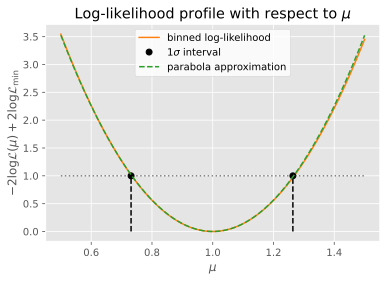

Shape analysis. Best fit parameter and uncertainty:



<IPython.core.display.Latex object>

In [ ]:
mu_axis_values = np.linspace(0.5, 1.5, 200)
binned_loglike_values = np.array([bll(mu) for mu in mu_axis_values]).flatten()

plt.plot(mu_axis_values, binned_loglike_values - min(binned_loglike_values), color = 'tab:orange', 
         label='binned log-likelihood')
plt.hlines(1, min(mu_axis_values), max(mu_axis_values), linestyle= ':', color= 'tab:gray')

idx = np.argwhere(np.diff(np.sign(
        binned_loglike_values - min(binned_loglike_values) - 1
        ))).flatten()

plt.xlabel(r'$\mu$')
plt.ylabel(r'$-2\log {\cal L}(\mu) + 2\log {\cal L}_{\rm min}$')
plt.title(r'Log-likelihood profile with respect to $\mu$')

plt.plot(mu_axis_values[idx], [1, 1], 'ko', label=r'$1\sigma$ interval')
plt.plot(mu_axis_values[idx[0]]*np.ones(2), [0, 1], 'k--')
plt.plot(mu_axis_values[idx[1]]*np.ones(2), [0, 1], 'k--')
sigma_mu = np.diff(mu_axis_values[idx])/2
plt.plot(mu_axis_values, ((mu_axis_values-1)/sigma_mu)**2, linestyle='--',
         color= 'tab:green', label='parabola approximation')
plt.legend(facecolor = 'w')
plt.show()

# Defining the binned log-likelihood best fit mu parameter:
muhat = mu_axis_values[np.argmin(binned_loglike_values)]

# Printing the output of the fit:
print('Shape analysis. Best fit parameter and uncertainty:\n')
pprint(muhat, mu_axis_values[idx[1]] - muhat, abs(mu_axis_values[idx[0]] - muhat))

The obtained value is consistent with the previous one within a $1\sigma$ range.